In [1]:
# Genetic Algorithm for mTSP using the flow from Electronics 2024
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tracemalloc
import math
import random

from typing import List, Tuple

SEED = 42  
random.seed(SEED)
np.random.seed(SEED)


class RLGA_mTSP:
    def __init__(self, distance_matrix: np.ndarray, m: int = 3,
                 pop_size: int = 100, generations: int = 300,
                 epsilon: float = 0.1, epsilon_decay: float = 0.99):
        
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.m = m
        self.pop_size = pop_size
        self.generations = generations
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.depot = 0

        self.crossover_rates = [0.7, 0.8, 0.9]
        self.mutation_rates = [0.05, 0.1, 0.15]
        self.Q = {}
        self.current_pc = 0.8
        self.current_pm = 0.1

        self.last_best_fitness = float('inf')

    def initialize_population(self) -> List[List[int]]:
        cities = list(range(1, self.n_cities))
        return [random.sample(cities, len(cities)) for _ in range(self.pop_size)]

    def decode_solution(self, chromosome: List[int]) -> List[List[int]]:
        routes = [[] for _ in range(self.m)]
        for i, city in enumerate(chromosome):
            routes[i % self.m].append(city)
        return routes

    def calculate_fitness(self, chromosome: List[int]) -> float:
        routes = self.decode_solution(chromosome)
        route_distances = [
            sum(self.distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1))
            if len(route) > 1 else 0
            for route in [[self.depot] + r + [self.depot] for r in routes]
        ]
        return max(route_distances) if route_distances else float('inf')

    def tournament_selection(self, population: List[List[int]], fitness: List[float]) -> List[int]:
        i, j, k = random.sample(range(len(population)), 3)
        best_idx = min([i, j, k], key=lambda idx: fitness[idx])
        return population[best_idx].copy()

    def partially_mapped_crossover(self, p1: List[int], p2: List[int]) -> Tuple[List[int], List[int]]:
        if random.random() > self.current_pc:
            return p1.copy(), p2.copy()

        size = len(p1)
        cx_point1, cx_point2 = sorted(random.sample(range(size), 2))
        
        def pmx(parent1, parent2):
            child = [None] * size
            child[cx_point1:cx_point2] = parent1[cx_point1:cx_point2]
            for i in range(cx_point1, cx_point2):
                if parent2[i] not in child:
                    val = parent2[i]
                    idx = i
                    while True:
                        val = parent1[idx]
                        idx = parent2.index(val)
                        if child[idx] is None:
                            child[idx] = parent2[i]
                            break
            for i in range(size):
                if child[i] is None:
                    child[i] = parent2[i]
            return child

        return pmx(p1, p2), pmx(p2, p1)

    def index_mutation(self, chromosome: List[int]) -> List[int]:
        if random.random() < self.current_pm:
            i = random.randint(0, len(chromosome) - 1)
            available_values = [v for v in range(1, self.n_cities) if v not in chromosome or chromosome.index(v) == i]
            if available_values:
                chromosome[i] = random.choice(available_values)
        return chromosome

    def update_q(self, state: str, action: Tuple[float, float], reward: float):
        alpha = 0.1
        if state not in self.Q:
            self.Q[state] = { (pc, pm): 0.0 for pc in self.crossover_rates for pm in self.mutation_rates }
        self.Q[state][action] += alpha * (reward - self.Q[state][action])

    def select_action(self, state: str) -> Tuple[float, float]:
        if state not in self.Q:
            self.Q[state] = { (pc, pm): 0.0 for pc in self.crossover_rates for pm in self.mutation_rates }
        if random.random() < self.epsilon:
            return random.choice(self.crossover_rates), random.choice(self.mutation_rates)
        return max(self.Q[state].items(), key=lambda x: x[1])[0]

    def get_state(self, fitness_list: List[float]) -> str:
        diversity = np.std(fitness_list)
        improvement = self.last_best_fitness - min(fitness_list)
        diversity_level = "high" if diversity > np.mean(fitness_list) * 0.1 else "low"
        improvement_level = "good" if improvement > 0 else "poor"
        return f"{diversity_level}_{improvement_level}"

    def run(self):
        population = self.initialize_population()
        best_solution = None
        best_fitness = float('inf')
        fitness_history = []

        for gen in range(self.generations):
            fitness_scores = [self.calculate_fitness(ind) for ind in population]
            best_idx = np.argmin(fitness_scores)
            if fitness_scores[best_idx] < best_fitness:
                best_fitness = fitness_scores[best_idx]
                best_solution = population[best_idx].copy()

            fitness_history.append(best_fitness)
            state = self.get_state(fitness_scores)
            self.current_pc, self.current_pm = self.select_action(state)

            new_population = []
            elite = population[best_idx].copy()
            new_population.append(elite)

            while len(new_population) < self.pop_size:
                p1 = self.tournament_selection(population, fitness_scores)
                p2 = self.tournament_selection(population, fitness_scores)
                c1, c2 = self.partially_mapped_crossover(p1, p2)
                c1 = self.index_mutation(c1)
                c2 = self.index_mutation(c2)
                new_population.extend([c1, c2])

            population = new_population[:self.pop_size]

            reward = (self.last_best_fitness - best_fitness) / (abs(self.last_best_fitness) + 1e-6)
            self.update_q(state, (self.current_pc, self.current_pm), reward)
            self.last_best_fitness = best_fitness
            self.epsilon *= self.epsilon_decay

            if gen % 20 == 0:
                print(f"Gen {gen}: Best max route length = {best_fitness:.2f}, Pc = {self.current_pc:.2f}, Pm = {self.current_pm:.2f}")

        routes = self.decode_solution(best_solution)
        route_distances = [
            sum(self.distance_matrix[r[i]][r[i+1]] for i in range(len(r)-1))
            for r in [[self.depot] + route + [self.depot] for route in routes]
        ]
        total_distance = sum(route_distances)
        balance_metric = max(route_distances) - min(route_distances) if route_distances else 0

        return routes, total_distance, best_fitness, balance_metric, fitness_history
    
def detect_convergence(fitness_list, window=5, threshold=1e-3):
    """Detect convergence in fitness evolution"""
    if len(fitness_list) < window:
        return len(fitness_list)
    for i in range(len(fitness_list) - window):
        if abs(fitness_list[i] - fitness_list[i + window]) < threshold:
            return i + window
    return len(fitness_list)


# Load real distance matrix or create example
try:
    distance_df = pd.read_csv('../data/HN_distance_matrix.csv', index_col=0)
    distance_matrix = distance_df.values
    print("Loaded real distance matrix")
except:
    # Fallback to example matrix
    n_cities = 127
    rng = np.random.default_rng(42)
    distance_matrix = rng.uniform(10, 100, size=(n_cities, n_cities))
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    np.fill_diagonal(distance_matrix, 0)
    print("Using example distance matrix")

print("Số thành phố:", distance_matrix.shape[0])
print("Ví dụ khoảng cách [0][1]:", distance_matrix[0][1])

Loaded real distance matrix
Số thành phố: 127
Ví dụ khoảng cách [0][1]: 21.48



=== RLGA - Số người bán hàng (m) = 1 ===
Gen 0: Best max route length = 1649.13, Pc = 0.80, Pm = 0.05


C:\Users\vthuy\AppData\Local\Temp\ipykernel_33008\814431389.py:149: RuntimeWarning: invalid value encountered in scalar divide
  reward = (self.last_best_fitness - best_fitness) / (abs(self.last_best_fitness) + 1e-6)


Gen 20: Best max route length = 1343.90, Pc = 0.70, Pm = 0.05
Gen 40: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 60: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 80: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 100: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 120: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 140: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 160: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 180: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 200: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 220: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 240: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 260: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Gen 280: Best max route length = 1290.72, Pc = 0.70, Pm = 0.05
Tổng quãng đường: 1290.72
Chiều dài route dài nhất (Max route length): 1290.72
Chênh lệch giữa các route (Balance metric):

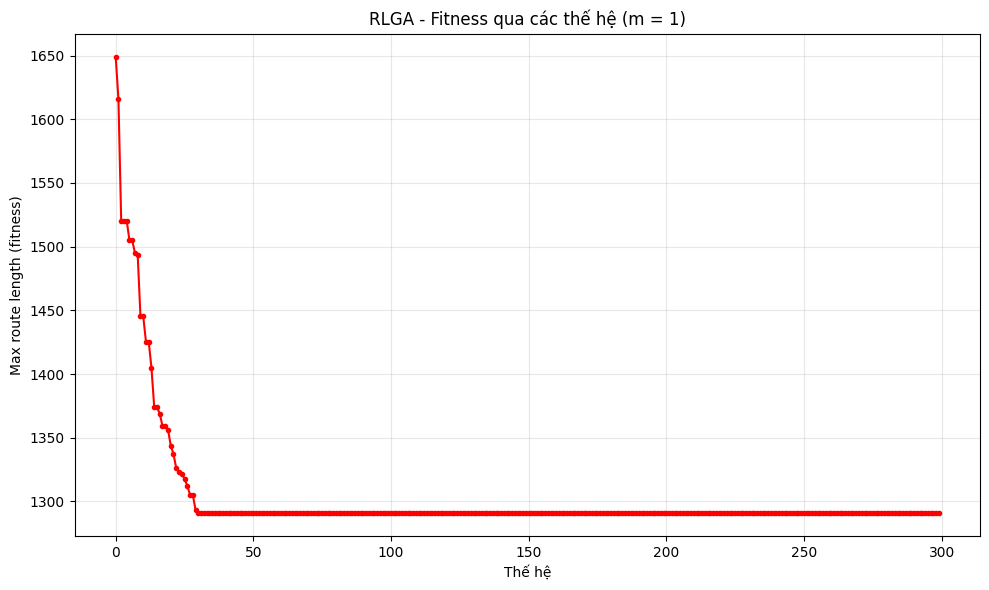


=== RLGA - Số người bán hàng (m) = 2 ===
Gen 0: Best max route length = 856.47, Pc = 0.70, Pm = 0.05
Gen 20: Best max route length = 753.15, Pc = 0.70, Pm = 0.05
Gen 40: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 60: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 80: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 100: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 120: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 140: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 160: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 180: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 200: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 220: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 240: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 260: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Gen 280: Best max route length = 727.82, Pc = 0.70, Pm = 0.05
Tổng quãng đường: 1452.32
Chiều dà

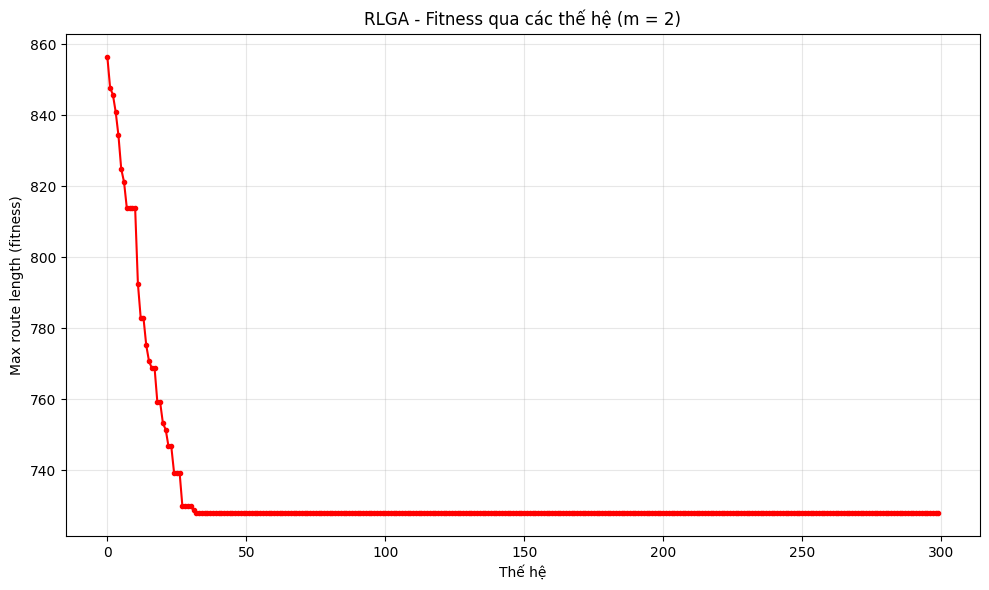


=== RLGA - Số người bán hàng (m) = 3 ===
Gen 0: Best max route length = 605.86, Pc = 0.70, Pm = 0.05
Gen 20: Best max route length = 536.88, Pc = 0.70, Pm = 0.05
Gen 40: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 60: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 80: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 100: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 120: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 140: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 160: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 180: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 200: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 220: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 240: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 260: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Gen 280: Best max route length = 531.24, Pc = 0.70, Pm = 0.05
Tổng quãng đường: 1590.13
Chiều dà

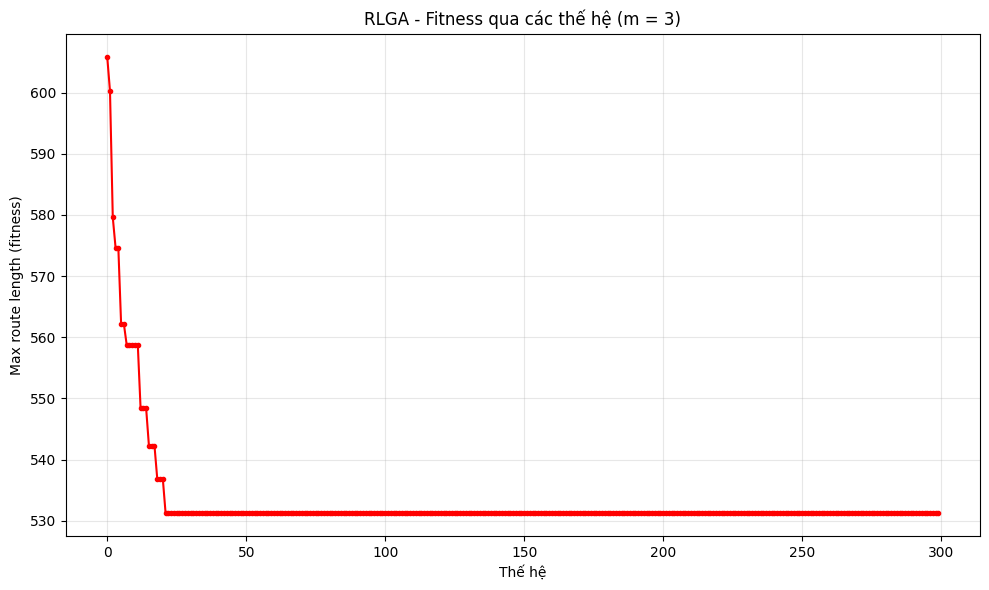

In [3]:
# File tổng hợp kết quả
summary_file = "results_summary_rlga.csv"
summary_cols = [
    "m", "total_distance", "fitness", "balance_metric",
    "exec_time", "converged_gen", "convergence_speed"
]

# Run experiments for different numbers of salesmen
for m in range(1, 4):
    print(f"\n=== RLGA - Số người bán hàng (m) = {m} ===")

    start_time = time.time()

    rlga = RLGA_mTSP(distance_matrix, m=m, pop_size=100, generations=300)
    routes, total_distance, max_route, balance_metric, fitness_per_generation = rlga.run()

    end_time = time.time()
    exec_time = end_time - start_time

    # Tính khoảng cách từng route
    route_distances = []
    for route in routes:
        if len(route) > 0:
            full_route = [0] + route + [0]
            distance = sum(distance_matrix[full_route[i]][full_route[i+1]] 
                           for i in range(len(full_route)-1))
            route_distances.append(distance)
        else:
            route_distances.append(0)

    # Chênh lệch giữa các route
    balance_metric = max(route_distances) - min(route_distances) if route_distances else 0

    # Phân tích hội tụ
    converged_gen = detect_convergence(fitness_per_generation)
    convergence_speed = (fitness_per_generation[0] - fitness_per_generation[-1]) / converged_gen if converged_gen > 0 else 0

    # In kết quả
    print(f"Tổng quãng đường: {total_distance:.2f}")
    print(f"Chiều dài route dài nhất (Max route length): {max_route:.2f}")
    print(f"Chênh lệch giữa các route (Balance metric): {balance_metric:.2f}")
    print(f"Thời gian thực thi: {exec_time:.4f} giây")
    print(f"Số vòng lặp cần thiết để hội tụ: {converged_gen}")
    print(f"Tốc độ hội tụ: {convergence_speed:.4f} đơn vị/gen")

    # Hiển thị từng route
    for i, route in enumerate(routes):
        if len(route) > 0:
            full_route = [0] + route + [0]
            print(f" - Tuyến {i+1} ({route_distances[i]:.2f}): {full_route}")
        else:
            print(f" - Tuyến {i+1} (0.00): [0]")

    # === Lưu file tổng hợp ===
    row = {
        "m": m,
        "total_distance": total_distance,
        "fitness": max_route,
        "balance_metric": balance_metric,
        "exec_time": exec_time,
        "converged_gen": converged_gen,
        "convergence_speed": convergence_speed
    }
    pd.DataFrame([row]).to_csv(summary_file, mode="a", index=False, header=False)

    # === Lưu fitness_per_generation riêng ===
    fitness_file = f"rlga_fitness_m{m}.csv"
    pd.DataFrame({
        "generation": range(len(fitness_per_generation)),
        "fitness": fitness_per_generation
    }).to_csv(fitness_file, index=False)

    # Vẽ biểu đồ fitness
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_per_generation, marker='o', linestyle='-', color='red', markersize=3)
    plt.title(f"RLGA - Fitness qua các thế hệ (m = {m})")
    plt.xlabel("Thế hệ")
    plt.ylabel("Max route length (fitness)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
